# TensorQTL QTL calling pipeline


This pipeline conduct QTL association study using tensorQTL. 

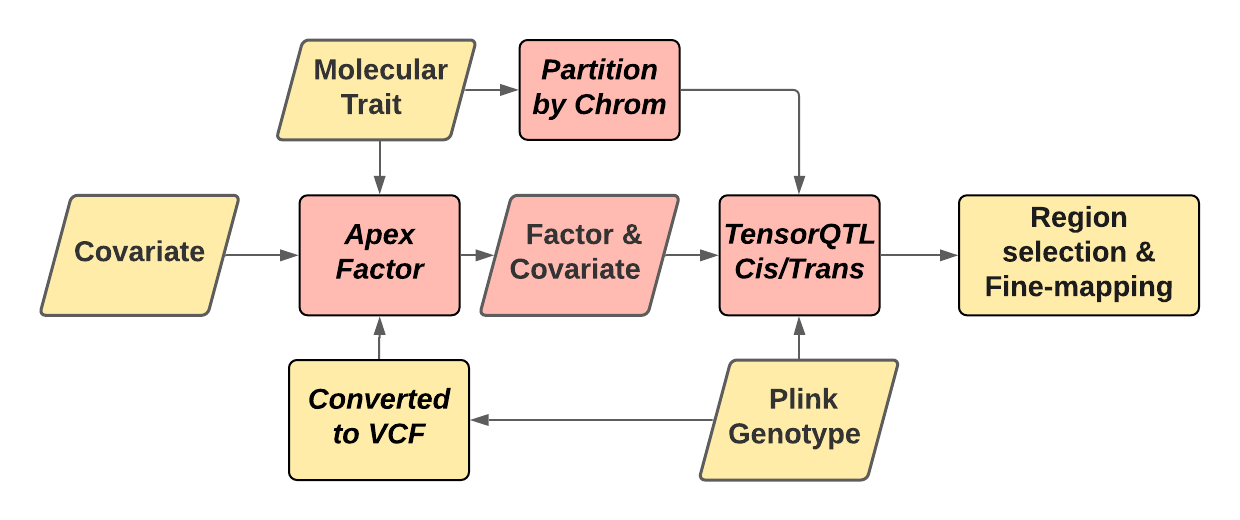

## Pre-requisites

This pipeline require the tensorQTL, fastparquet, and R:Tidyverse. A singularity container is provided along with the mwe


# Input and Output
## Input
- `--molecular-pheno`, The bed.gz file containing the table describing the molecular phenotype. It shall also have a tbi index accompaning it.


- `genotype_list` a list of whole genome plink file for each chromosome


- `grm_list` is a file containing list of grm matrixs that generated by the GRM module of this pipeline.

- `covariate` is a file with #id + samples name as colnames and each row a cov/factor/pc. Generated beforehand from the data_processing sections

## Output

A sets of sumstat files for each chromosome, one of which is the long table documenting the norminal QTL associations for each snps.

At the moment the generation of gene based QTL signal was disabled to avoid the breaking of the pipeline when all of the QTL association signal given are NAs





# Command interface 

# Working example


ERROR: Failed to locate twas_fusion.ipynb.sos



# Global parameter settings
The section outlined the parameters that can be set in the command interface.

In [5]:
[global]
# Path to the input molecular phenotype file, per chrm, in bed.gz format.
parameter: molecular_pheno = path
molecular_pheno_str = f'{molecular_pheno}'
# Covariate file, in similar format as the molecular_pheno
parameter: covariate = path
# Genotype file in plink trio format, per chrm
parameter: genotype_file = path
# An optional subset of region list containing a column of ENSG gene_id to limit the analysis
parameter: region_list = path("./")
# Path to the work directory of the analysis.
parameter: wd = path('./')
# Specify the number of jobs per run.
parameter: job_size = 2
# Container option for software to run the analysis: docker or singularity
parameter: container = ''
# Prefix for the analysis output
parameter: Prefix = 'ROSMAP'


# Specify the scanning window for the up and downstream radius to analyze around the region of interest, in units of bp
parameter: window = ['1000000']

## QTL Sumstat generation  
This step generate the cis-QTL summary statistics and vcov (covariate-adjusted LD) files for downstream analysis from summary statistics. The analysis is done per chromosome to reduce running time.

## Cis QTL Sumstat generation via tensorQTL



In [ ]:
[TensorQTL_cis_1]
input: molecular_pheno, genotype_file, covariate
output: f'{wd:a}/{_input[0]:bnnn}.cis_qtl_pairs.{molecular_pheno_str.split("/")[-1].split(".")[-4].replace("chr","")}.parquet',
        f'{wd:a}/{_input[0]:bnnn}.norminal.cis_long_table.txt'#,
        #f'{wd:a}/{_input[0]:bnnn}.emprical.cis_sumstats.txt'
task: trunk_workers = 1, trunk_size = 1, walltime = '12h',  mem = '40G', tags = f'{step_name}_{_output[0]:bn}'
bash: expand= "$[ ]", stderr = f'{_output[0]}.stderr', container = container,stdout = f'{_output[0]}.stdout'
    touch  $[_output[0]].time_stamp
python: expand= "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout'
    import pandas as pd
    import numpy as np
    import tensorqtl
    from tensorqtl import genotypeio, cis, trans
    ## Defineing parameter
    plink_prefix_path = $[_input[1]:nr]
    expression_bed = $[_input[0]:r]
    covariates_file = "$[_input[2]]"
    Prefix = "$[_output[0]:nn]"
    ## Loading Data
    phenotype_df, phenotype_pos_df = tensorqtl.read_phenotype_bed(expression_bed)
    ### Filter by the optional keep gene
    ##if $[region_list].is_file():
    ##    region = pd.read_csv("$[region_list]","\t")
    ##    keep_gene = region["gene_ID"].to_list()
    ##    phenotype_df = phenotype_df.query('gene_ID  in keep_gene')
    ##    phenotype_pos_df = phenotype_pos_df.query('gene_ID  in keep_gene')


    covariates_df = pd.read_csv(covariates_file, sep='\t', index_col=0).T
    pr = genotypeio.PlinkReader(plink_prefix_path)
    genotype_df = pr.load_genotypes()
    variant_df = pr.bim.set_index('snp')[['chrom', 'pos']]
    ## Retaining only common samples
    phenotype_df = phenotype_df[np.intersect1d(phenotype_df.columns, covariates_df.index)]
    covariates_df = covariates_df.transpose()[np.intersect1d(phenotype_df.columns, covariates_df.index)].transpose()
    ## cis-QTL mapping: nominal associations for all variant-phenotype pairs
    cis.map_nominal(genotype_df, variant_df,
                phenotype_df,
                phenotype_pos_df,
                Prefix, covariates_df=covariates_df)

    ## Load the parquet and save it as txt
    pairs_df = pd.read_parquet("$[_output[0]]")
    pairs_df.columns.values[6]  = "pval"
    pairs_df.columns.values[7]  = "beta"
    pairs_df.columns.values[8]  = "se"
    pairs_df = pairs_df.assign(
    alt = lambda dataframe: dataframe['variant_id'].map(lambda variant_id:variant_id.split("_")[1])).assign(
    ref = lambda dataframe: dataframe['variant_id'].map(lambda variant_id:variant_id.split("_")[2])).assign(
    pos = lambda dataframe: dataframe['variant_id'].map(lambda variant_id:variant_id.split("_")[0]))
    pairs_df.to_csv("$[_output[1]]", sep='\t',index = None)


[TensorQTL_cis_2]
input: molecular_pheno, genotype_file, covariate
output: f'{wd:a}/{_input[0]:bnnn}.emprical.cis_sumstats.txt'
task: trunk_workers = 1, trunk_size = 1, walltime = '12h',  mem = '40G', tags = f'{step_name}_{_output[0]:bn}'
bash: expand= "$[ ]", stderr = f'{_output}.stderr', container = container,stdout = f'{_output[0]}.stdout'
    touch  $[_output[0]].time_stamp
python: expand= "$[ ]", stderr = f'{_output}.stderr', stdout = f'{_output}.stdout'
    import pandas as pd
    import numpy as np
    import tensorqtl
    from tensorqtl import genotypeio, cis, trans
    ## Defineing parameter
    plink_prefix_path = $[_input[1]:nr]
    expression_bed = $[_input[0]:r]
    covariates_file = "$[_input[2]]"
    Prefix = "$[_output[0]:nn]"
    ## Loading Data
    phenotype_df, phenotype_pos_df = tensorqtl.read_phenotype_bed(expression_bed)
    ### Filter by the optional keep gene
    ##if $[region_list].is_file():
    ##    region = pd.read_csv("$[region_list]","\t")
    ##    keep_gene = region["gene_ID"].to_list()
    ##    phenotype_df = phenotype_df.query('gene_ID  in keep_gene')
    ##    phenotype_pos_df = phenotype_pos_df.query('gene_ID  in keep_gene')

    covariates_df = pd.read_csv(covariates_file, sep='\t', index_col=0).T
    pr = genotypeio.PlinkReader(plink_prefix_path)
    genotype_df = pr.load_genotypes()
    variant_df = pr.bim.set_index('snp')[['chrom', 'pos']]
    ## Retaining only common samples
    phenotype_df = phenotype_df[np.intersect1d(phenotype_df.columns, covariates_df.index)]
    covariates_df = covariates_df.transpose()[np.intersect1d(phenotype_df.columns, covariates_df.index)].transpose()
    # cis-QTL mapping: empirical p-values for phenotypes
    cis_df = cis.map_cis(genotype_df, variant_df, 
                     phenotype_df,
                     phenotype_pos_df,
                     covariates_df=covariates_df, seed=999)
    cis_df.index.name = "gene_id"
    cis_df.to_csv("$[_output[2]]", sep='\t')
[TensorQTL_cis_3]
output: f'{_input[1]:n}.reformmated.txt'
        f'{_input[1]:n}.trimmed.rds'
task: trunk_workers = 1, trunk_size = 1, walltime = '24h',  mem = '70G', tags = f'{step_name}_{_output[0]:bn}'
R: expand = "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',container = container,volumes = [f'{wd:ad}:{wd:ad}']
    library("dplyr")
    library("data.table")
    library("tibble")
    library("readr")
    library("modelr")
    library("purrr")
    data <- read_delim("$[_input[1]]",delim = "\t")%>%select(-gene_ID,-tss_distance, -af,-ma_count)
    data = data%>%group_by(variant_id)%>%top_n(-1, abs(pval_nominal))%>%mutate(chr = map_dbl(variant_id,~read.table(text = .x,sep = ":")[,1]),
                                                                         res = map_chr(variant_id,~read.table(text = .x,sep = ":",colClasses = "character")$V2),
                                                                         pos = map_dbl(res,~read.table(text = .x,sep = "_")$V1,as.is = T),
                                                                         ref = map_chr(variant_id,~read.table(text = .x,sep = "_",colClasses = "character")$V2),
                                                                         alt = map_chr(variant_id,~read.table(text = .x,sep = "_",colClasses = "character")$V3))%>%select(-res)
    
    data %>%write_delim("$[_output]",delim = "\t")

## Trans QTL Sumstat generation via tensorQTL


In [ ]:
[TensorQTL_trans_1]
input: molecular_pheno, genotype_file, covariate
output: f'{wd:a}/{_input[0]:bnnn}.trans_sumstats.txt'
parameter: batch_size = 10000
parameter: pval_threshold = 1e-5
parameter: maf_threshold = 0.05

task: trunk_workers = 1, trunk_size = 1, walltime = '12h',  mem = '40G', tags = f'{step_name}_{_output[0]:bn}'
bash: expand= "$[ ]", stderr = f'{_output[0]}.stderr', container = container,stdout = f'{_output[0]}.stdout'
    touch  $[_output[0]].time_stamp
python: expand= "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',container =container 
    import pandas as pd
    import numpy as np
    import tensorqtl
    from tensorqtl import genotypeio, cis, trans
    ## Defineing parameter
    plink_prefix_path = $[_input[2]:r]
    expression_bed = $[_input[0]:r]
    covariates_file = "$[_input[2]]"
    Prefix = "$[_output[0]:nnn]"
    ## Loading Data
    phenotype_df, phenotype_pos_df = tensorqtl.read_phenotype_bed(expression_bed)


    ##### Filter by the optional keep gene
    ##if $[region_list].is_file():
    ##    region = pd.read_csv("$[region_list]","\t")
    ##    keep_gene = region["gene_ID"].to_list()
    ##    phenotype_df = phenotype_df.query('gene_ID  in keep_gene')
    ##    phenotype_pos_df = phenotype_pos_df.query('gene_ID  in keep_gene')


    covariates_df = pd.read_csv(covariates_file, sep='\t', index_col=0).T
    pr = genotypeio.PlinkReader(plink_prefix_path)
    genotype_df = pr.load_genotypes()
    variant_df = pr.bim.set_index('snp')[['chrom', 'pos']]
    ## Retaining only common samples
    phenotype_df = phenotype_df[np.intersect1d(phenotype_df.columns, covariates_df.index)]
    covariates_df.transpose()[np.intersect1d(phenotype_df.columns, covariates_df.index)].transpose()
    ## Trans analysis
    trans_df = trans.map_trans(genotype_df, phenotype_df, covariates_df, batch_size=$[batch_size],
                           return_sparse=True, pval_threshold=$[pval_threshold], maf_threshold=$[maf_threshold])

    ## Filter out cis signal
    trans_df = trans.filter_cis(trans_df, phenotype_pos_df.T.to_dict(), variant_df, window=$[window])
    ## Output
    trans_df.columns.values[1]  = "gene_ID"
    trans_df.columns.values[6]  = "pval"
    trans_df.columns.values[7]  = "beta"
    trans_df.columns.values[8]  = "se"
    trans_df = pairs_df.assign(
    alt = lambda dataframe: dataframe['variant_id'].map(lambda variant_id:variant_id.split("_")[1])).assign(
    ref = lambda dataframe: dataframe['variant_id'].map(lambda variant_id:variant_id.split("_")[2])).assign(
    pos = lambda dataframe: dataframe['variant_id'].map(lambda variant_id:variant_id.split("_")[0]))
    trans_df.to_csv("$[_output[0]]", sep='\t')

[TensorQTL_trans_2]
output: f'{_input[1]:n}.reformmated.txt'
        f'{_input[1]:n}.trimmed.rds'
task: trunk_workers = 1, trunk_size = 1, walltime = '24h',  mem = '70G', tags = f'{step_name}_{_output[0]:bn}'
R: expand = "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',container = container,volumes = [f'{wd:ad}:{wd:ad}']
    library("dplyr")
    library("data.table")
    library("tibble")
    library("readr")
    library("modelr")
    library("purrr")
    data <- read_delim("$[_input[1]]",delim = "\t")%>%select(-gene_ID,-tss_distance, -af,-ma_count)
    data = data%>%group_by(variant_id)%>%top_n(-1, abs(pval_nominal))%>%mutate(chr = map_dbl(variant_id,~read.table(text = .x,sep = ":")[,1]),
                                                                         res = map_chr(variant_id,~read.table(text = .x,sep = ":",colClasses = "character")$V2),
                                                                         pos = map_dbl(res,~read.table(text = .x,sep = "_")$V1,as.is = T),
                                                                         ref = map_chr(variant_id,~read.table(text = .x,sep = "_",colClasses = "character")$V2),
                                                                         alt = map_chr(variant_id,~read.table(text = .x,sep = "_",colClasses = "character")$V3))%>%select(-res)
    
    data %>%write_delim("$[_output]",delim = "\t")

In [ ]:
[output_processing]
# Temp version, will change after adapting to what metal need
